# Market Cap Data Wrangling

This notebook uses **CryptoDataPy** to collect, clean and wrangle market cap data used to analyzed digital assets.

# Data Collection

We will use **CryptoDataPy**, a python library we have created to make the process of analyzing digital assets as easy as possible. It allows you to create high quality ready-for-analysis data sets from a variety of sources with only a few lines of code. For more information, see our docs: https://cryptodatapy.readthedocs.io/en/latest/#

<br>


Our data set will be collected from the following sources: CryptoCompare, CoinMetrics and Glassnode.


**Note:** we recommend following the instructions carefully to avoid hitting web API rate limits. Alternatively, those paying for premium packages from any of our data sources can include their API keys to remove rate limit restrictions on freemium offerings. See CryptoDataPy docs for more information on specifying the API key parameter.


## Market Data

In [1]:
import pandas as pd
import numpy as np
from time import sleep
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from cryptodatapy.util.datacatalog import DataCatalog 
from cryptodatapy.extract.datarequest import DataRequest
from cryptodatapy.extract.getdata import GetData
from cryptodatapy.transform.clean import CleanData

### Asset Universe

Since factor-based strategies are implemented with long/short positions, we restrict our asset universe to liquid assets trading on the Binance perpetual futures exchange which includes ~ 150 assets.

Our universe is filtered down futher to assets with spot prices that go further back to increase our sample size and the statistical/economic significance of our results.

To do this, we find the intersection of assets with perpetual futures and spot traded on Binance as well as CryptoCompare's aggregated exchange for extended backhistory.

In [2]:
# get all Binance perp futures tickers from CCXT
data_req = DataRequest(source='ccxt')
fut_tickers = GetData(data_req).get_meta(method='get_markets_info', exch='binanceusdm', as_list=True)

In [3]:
# get all Binance spot tickers from CCXT
data_req = DataRequest(source='ccxt')
spot_tickers = GetData(data_req).get_meta(method='get_markets_info', exch='binance', as_list=True)

In [4]:
# find tickers intersection
binance_tickers = [ticker for ticker in fut_tickers if ticker in spot_tickers]

In [5]:
# keep only USDT tickers from Binance
bin_tickers = []
for ticker in binance_tickers:
    if '/' in ticker and ticker.split('/')[1] == 'USDT':
        bin_tickers.append(ticker.split('/')[0])

In [6]:
# get spot tickers from cryptocompare 
data_req = DataRequest(source='cryptocompare')
cc_tickers = GetData(data_req).get_meta(method='get_assets_info', as_list=True)

In [7]:
# find intersecting tickers for Binance and CryptoCompare
tickers = [ticker for ticker in bin_tickers if ticker in cc_tickers]

In [8]:
# remove FTT and SRM
tickers = [ticker for ticker in tickers if ticker not in ['FTT', 'SRM']]

### Stablecoins

Many data sources will return on-chain data for stablecoins which may not be of interest to us in this case.

**CryptoDataPy** allows us to pull a list of stablecoins in order to remove those assets from our analysis.

In [9]:
# get stablecoin list
dc = DataCatalog()
sc_list = dc.get_tickers_metadata(cat='crypto').index.to_list()

## Market Cap

We can retrieve market cap data from CoinMetrics and Glassnode using **CryptoDataPy**.

We break up ticker and fields into batches and restrict API calls to below 30 per minute to avoid hitting rate limits.

- Market cap, realized market cap and free float market cap from CoinMetrics

In [10]:
mkt_cap_fields = ['mkt_cap', 'mkt_cap_real', 'mkt_cap_ff']

In [11]:
# get available tickers for market cap from CoinMetrics
data_req = DataRequest(source='coinmetrics', fields=mkt_cap_fields)
cm_mktcap_tickers = GetData(data_req).get_meta(method='get_onchain_tickers_list', data_req=data_req)

In [12]:
cm_mktcap_tickers = [ticker for ticker in cm_mktcap_tickers if ticker.split('_')[0].upper() not in sc_list]
cm_mktcap_tickers = [ticker for ticker in cm_mktcap_tickers if ticker.split('_')[0].upper() in tickers]

In [13]:
len(cm_mktcap_tickers)

44

In [14]:
# split mkt tickers list into 4 batchs to avoid going over rate limit
# 11 tickers x 3 fields 
cm_mktcap_tickers1 = cm_mktcap_tickers[:11]
cm_mktcap_tickers2 = cm_mktcap_tickers[11:22]
cm_mktcap_tickers3 = cm_mktcap_tickers[22:33]
cm_mktcap_tickers4 = cm_mktcap_tickers[33:44]

In [15]:
# pull first batch, wait 60 seconds
data_req = DataRequest(source='coinmetrics', tickers=cm_mktcap_tickers1, fields=mkt_cap_fields)
cm_mktcap_df1 = GetData(data_req).get_series()
sleep(60)

In [16]:
# pull second batch
data_req = DataRequest(source='coinmetrics', tickers=cm_mktcap_tickers2, fields=mkt_cap_fields)
cm_mktcap_df2 = GetData(data_req).get_series()
sleep(60)

In [17]:
# pull second batch
data_req = DataRequest(source='coinmetrics', tickers=cm_mktcap_tickers3, fields=mkt_cap_fields)
cm_mktcap_df3 = GetData(data_req).get_series()
sleep(60)

In [18]:
# pull second batch
data_req = DataRequest(source='coinmetrics', tickers=cm_mktcap_tickers4, fields=mkt_cap_fields)
cm_mktcap_df4 = GetData(data_req).get_series()
sleep(60)

In [19]:
# concat batches
cm_mktcap_df = pd.concat([cm_mktcap_df1, cm_mktcap_df2, cm_mktcap_df3, cm_mktcap_df4], axis=0).sort_index()

In [20]:
# remove '_' from tickers
cm_mktcap_df.reset_index(inplace=True)
cm_mktcap_df.ticker = cm_mktcap_df.ticker.str.split('_').str[0]
# reset index
cm_mktcap_df.set_index(['date', 'ticker'], inplace=True)
# drop dups
cm_mktcap_df = cm_mktcap_df.drop_duplicates()

In [21]:
cm_mktcap_df.head()

mkt_cap  mkt_cap_real     mkt_cap_ff
date       ticker                                            
2010-07-18 BTC        295959.152   2026.585401     295959.152
2010-07-19 BTC          279285.2   4463.911468       279285.2
2010-07-20 BTC      259000.40499    5741.95866   259000.40499
2010-07-21 BTC     275266.471297   7176.328942  275266.471297
2010-07-22 BTC     203749.573975   8107.064743  203749.573975

- Market cap from Glassnode

In [22]:
# filter tickers list for gn
data_req = DataRequest(source='glassnode')
gn_avail_tickers = GetData(data_req).get_meta(attr='assets')

In [23]:
gn_tickers = [ticker for ticker in gn_avail_tickers if ticker in tickers]

In [24]:
len(gn_tickers)

36

In [25]:
# batch tickers
gn_tickers1 = gn_tickers[:18]
gn_tickers2 = gn_tickers[18:]

In [26]:
# get mkt cap
data_req = DataRequest(source='glassnode', tickers=gn_tickers1, fields='mkt_cap')
gn_mktcap_df1 = GetData(data_req).get_series()
sleep(60)

In [27]:
# get mkt cap
data_req = DataRequest(source='glassnode', tickers=gn_tickers2, fields='mkt_cap')
gn_mktcap_df2 = GetData(data_req).get_series()
sleep(60)

In [28]:
# concat batches
gn_mktcap_df = pd.concat([gn_mktcap_df1, gn_mktcap_df2], axis=0).sort_index()

In [29]:
# merge and drop dups
mktcap_df = pd.concat([cm_mktcap_df, gn_mktcap_df])
mktcap_df = mktcap_df[~mktcap_df.index.duplicated()]

In [30]:
mktcap_df.head()

mkt_cap  mkt_cap_real     mkt_cap_ff
date       ticker                                            
2010-07-18 BTC        295959.152   2026.585401     295959.152
2010-07-19 BTC          279285.2   4463.911468       279285.2
2010-07-20 BTC      259000.40499    5741.95866   259000.40499
2010-07-21 BTC     275266.471297   7176.328942  275266.471297
2010-07-22 BTC     203749.573975   8107.064743  203749.573975

# Data Cleaning

### Market Cap: 

- Clean market cap data

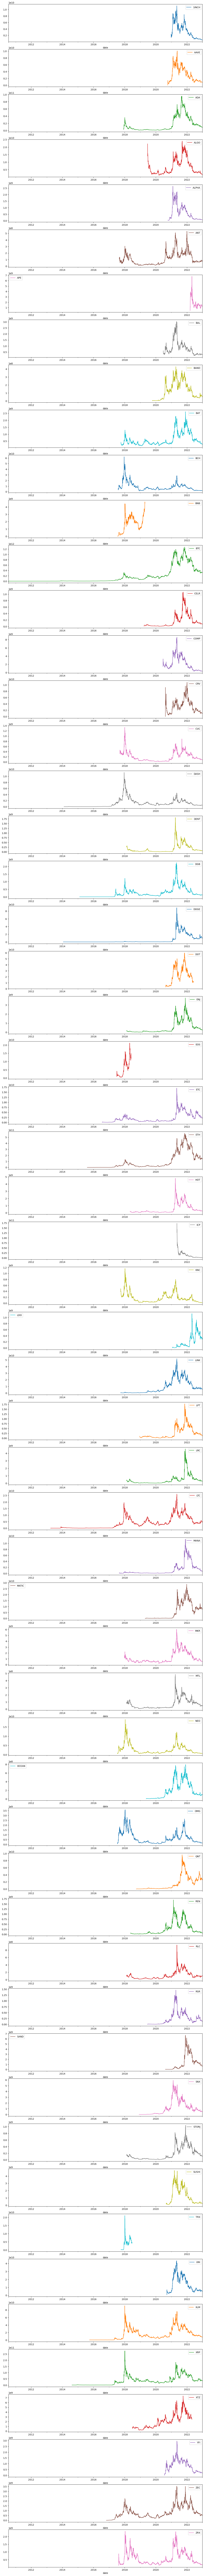

In [31]:
# plot mkt cap data
mktcap_df.unstack().mkt_cap.plot(subplots=True, sharex=False, figsize=(15,200));

In [32]:
# tickers with missing values
bad_tickers = ['BNB', 'DOT', 'EOS', 'TRX', 'XTZ']

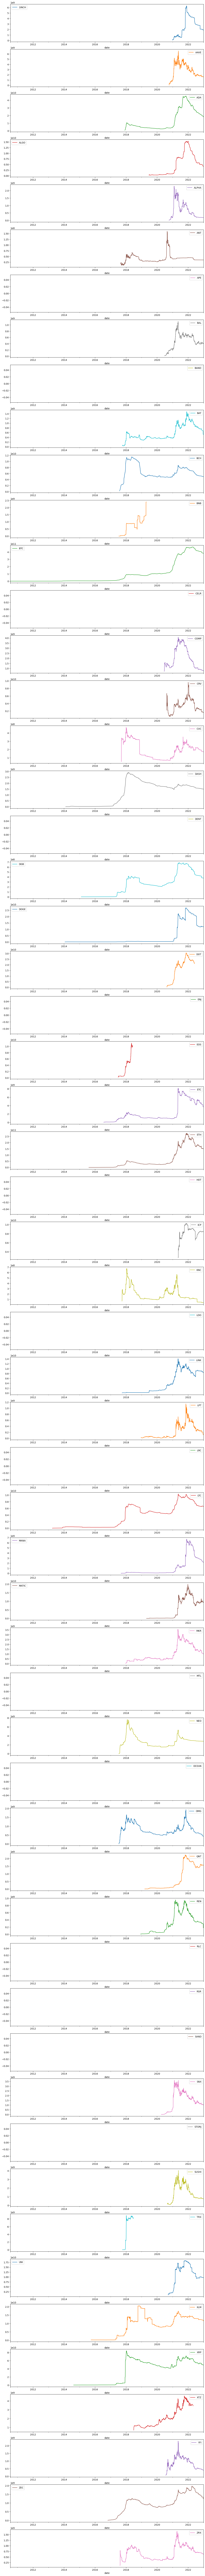

In [33]:
mktcap_df.unstack().mkt_cap_real.plot(subplots=True, sharex=False, figsize=(15,200));

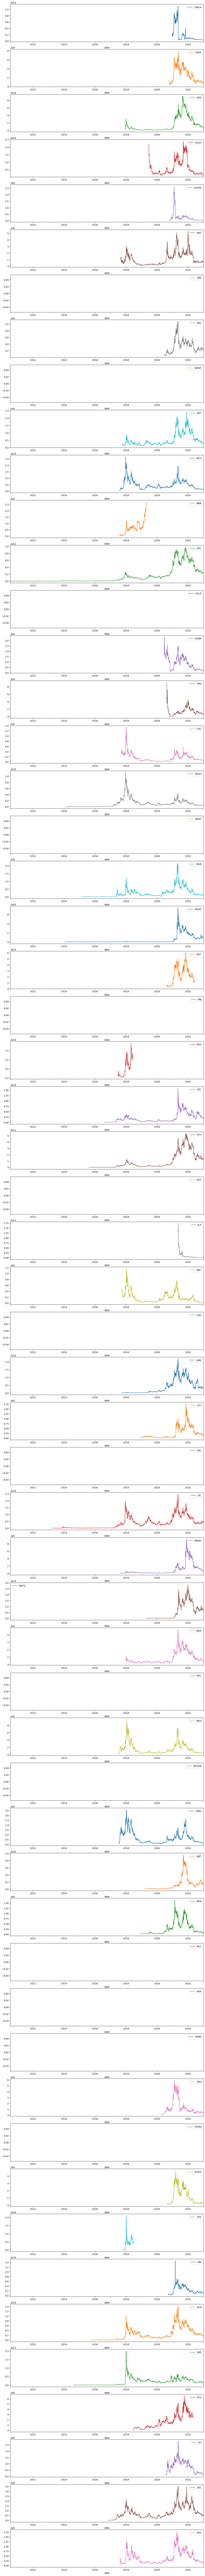

In [34]:
mktcap_df.unstack().mkt_cap_ff.plot(subplots=True, sharex=False, figsize=(15,200));

In [35]:
# drop bad tickers
mktcap_df.drop(bad_tickers, level=1, inplace=True)

In [36]:
len(mktcap_df.index.get_level_values(1).unique().to_list())

52

In [37]:
clean_mktcap_df = CleanData(mktcap_df).filter_outliers(od_method='iqr', thresh_val=10).\
                   repair_outliers(imp_method='fcst').\
                   filter_missing_vals_gaps(gap_window=30).get(attr='df')

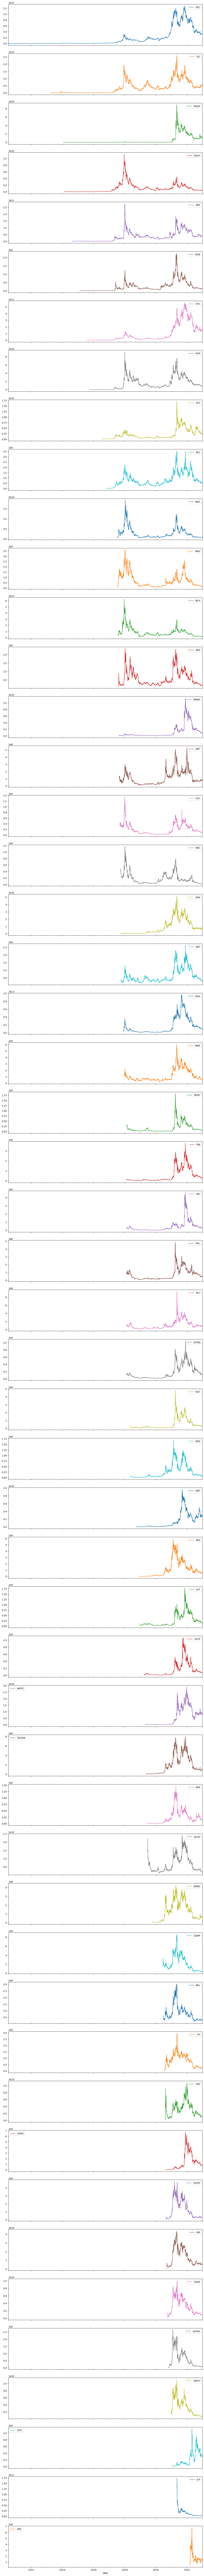

In [38]:
clean_mktcap_df.unstack().mkt_cap.plot(subplots=True, figsize=(15,200));

In [41]:
clean_mktcap_df.to_csv('../src/factorlab/datasets/data/crypto_mkt_cap.csv')